# Для исследования разностных схем будем использовать задачу Самарского-Соболя-Зельдовича

$$
\begin{cases}
 \frac{\partial u}{\partial t} = \frac{\partial}{\partial x}u^{\alpha}\frac{\partial u}{\partial x} \\
 u(x, 0) = 0 \\
 u(0, t) = ct^{1/\alpha} \\
 \lim_{x \rightarrow +\inf}u(x,t) = 0
 \end{cases}
$$

## Неявная разностная схема с нелинейностью на нижнем слое

Для численного решения задачи будем использовать неявную разностную схему с нелинейностью на нижнем слое

$$
\frac{y^{n+1}_{m} - y^{n}_{m}}{\tau} = \frac{1}{h}\left[k^n_{m + 1/2}\frac{y^{n+1}_{m+1} - y^{n+1}_{m}}{h} - k^n_{m - 1/2}\frac{y^{n+1}_{m} - y^{n+1}_{m - 1}}{h}\right]
$$

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.pyplot import axes
from celluloid import Camera
from numba import njit
import utils

### Реализация

In [40]:
@njit
def k_12(y_m, y_m_1, alpha):
    return (y_m ** alpha + y_m_1 ** alpha) / 2

In [41]:
@njit
def make_diagonals(u, n, tau, h, M, alpha=2.5, kappa=0.2):
    # init variables
    a = np.zeros(M - 1)
    b = np.zeros(M)
    c = np.zeros(M - 1)
    d = np.zeros(M)
    sigma = kappa * tau / h ** 2
    y = u[n, :]
    # first row
    b[0] = 1
    d[0] = - u[n + 1, 0]
    # rows m = 2,...,M - 1
    for m in range(1, M - 1):
        a[m - 1] = k_12(y[m - 1], y[m], alpha) * sigma
        c[m] = k_12(y[m], y[m + 1], alpha) * sigma
        b[m] = 1 + a[m - 1] + c[m]
        d[m] = - y[m]
    # last row
    m = M - 1
    b[m] = 1
    d[m] = - y[m]
    return a, b, c, d

In [42]:
@njit
def thomas_solver(a, b, c, d):
    # init arrays
    M = len(b)
    u_sol = np.zeros(M)
    P = np.zeros(M)
    Q = np.zeros(M)
    # Forward first coefs
    P[0] = c[0] / b[0]
    Q[0] = - d[0] / b[0]
    # Forward coefs n = 1 ... M - 1
    for m in range(1, M - 1):
        P[m] = c[m] / (b[m] - a[m - 1] * P[m - 1])
        Q[m] = (a[m - 1] * Q[m - 1] - d[m]) / (b[m] - a[m - 1] * P[m - 1])
    #Forward last
    m = M - 1
    Q[m] = (a[m - 1] * Q[m - 1] - d[m]) / (b[m] - a[m - 1] * P[m - 1])

    # backward
    u_sol[-1] = Q[-1]
    for m in range(M - 1, -1, -1):
        u_sol[m - 1] = P[m - 1] * u_sol[m] + Q[m - 1]

    return u_sol

### Применение

In [43]:
# Начальные значения
a = 0
b = 2
t_0 = 0
T = 4
To = 2
const = 3
alpha = 2.5
kappa = 0.2

print(f'v = {np.sqrt(const ** (1 / alpha) * kappa / alpha)}')

v = 0.3523459179744088


In [44]:
# Число узлов
N = 6000
M = 100

# Размер шага сетки
h = (b - a) / (M - 1)
tau = (T - t_0) / (N - 1)
print(f'{h=: .8f}, {tau=: .8f}')
print(f'sigma = {tau / h ** 2 * 0.5: .4f}')

h= 0.02020202, tau= 0.00066678
sigma =  0.8169


In [45]:
t = np.linspace(t_0, T, N)
x = np.linspace(a, b, M)

In [46]:
u = np.zeros((N, M), dtype=np.double)
u[:, 0] = const * t ** (1 / alpha)

In [47]:
for n in tqdm(range(N - 1)):
    a_e, b_e, c_e, d_e = make_diagonals(u, n, tau, h, M, alpha=alpha, kappa=kappa)
    u_sol = thomas_solver(a_e, b_e, c_e, d_e)
    u[n + 1, :] = u_sol

  0%|          | 0/5999 [00:00<?, ?it/s]

#### Визуализация

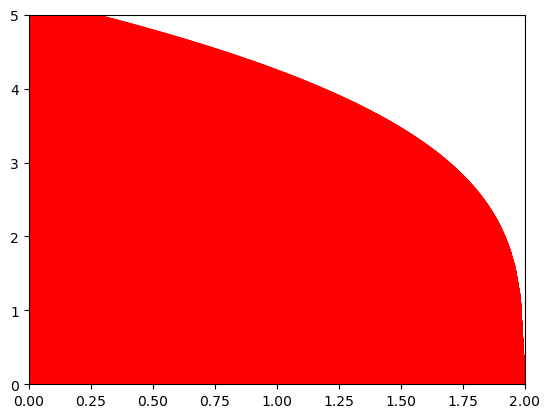

In [58]:
fig = plt.figure()
camera = Camera(fig)
ax = axes(xlim=(a, b), ylim=(0, 5))

for i in range(0, N, 10):
    ax.plot(x, u[i, :], color="red")
    ax.fill_between(x, u[i, :], color='red', alpha=0.3)
    camera.snap()

In [59]:
animation = camera.animate()
animation.save('spitz.gif', writer = 'imagemagick', fps=tau * 10 * 1e3)

MovieWriter imagemagick unavailable; using Pillow instead.


In [60]:
from IPython.display import Image
Image(url='spitz.gif')

In [65]:
matrix = np.arange(4).reshape(2, 2)
AA = np.array([matrix, matrix, matrix])
AA[0]

array([[0, 1],
       [2, 3]])

In [75]:
AA.shape

(3, 2, 2)

In [77]:
matrix

array([[0, 1],
       [2, 3]])

In [84]:
%%timeit
inv_matr = np.array([[matrix[1, 1], -matrix[0, 1]],[- matrix[1, 0], matrix[0, 0]]])

3.44 µs ± 361 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [87]:
matrix @ matrix

array([[ 2,  3],
       [ 6, 11]])